In [1]:

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras
import tensorflow as tf
from scipy.stats import t
from scipy.stats import norm
from tensorflow.keras import backend as K
import time

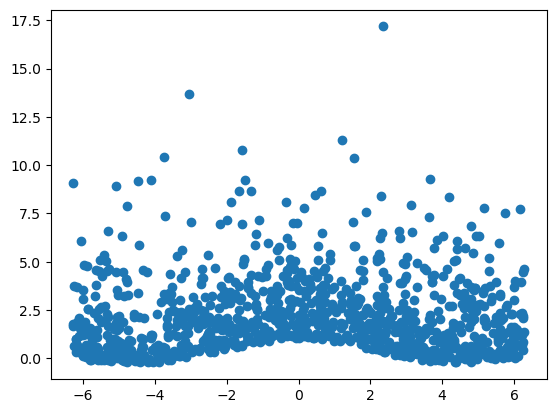

In [2]:
np.random.seed(40)

n_samples = 1000  # Example number of samples

# Generate noise from chi-square distribution with degree of freedom 2
noise = np.random.chisquare(df=2, size=n_samples)

# Generate X values uniformly
X = np.random.uniform(low=-2 * np.pi, high=2 * np.pi, size=(n_samples, 1))

# Compute y values with the chi-square noise
y = (np.sin(X[:, 0]) / X[:, 0]) + noise
y_ = (np.sin(X[:, 0]) / X[:, 0])

# Prepare data for training
X_train = X.reshape(-1)
y_train = y.reshape(-1)
y_train = np.stack((y_train, y_train), axis=1)

# Create a grid for visualization
x_grid = np.linspace(-6, 6, 3000)
# plot the points
plt.scatter(X_train,y_train[:,0])


In [3]:

# hyperparameters for Tube Loss
q = 0.80 # target coverage
def confidence_loss(y_true, y_pred):
    y_true = y_true[:, 0]
    f2 = y_pred[:, 0]
    f1 = y_pred[:, 1]

    c1 = (1 - q) * (f2 - y_true)
    c2 = (1 - q) * (y_true - f1)
    c3 = q * (f1 - y_true)
    c4 = q * (y_true - f2)

    # Use tf.where to create a tensor based on conditions
    loss_part1 = tf.where(y_true > r * (f1 + f2), c1, c2)
    loss_part2 = tf.where(f1 > y_true, c3, c4)

    final_loss = tf.where(tf.logical_and(y_true <= f2, y_true >= f1), loss_part1, loss_part2) 

    # Reduce the loss to a scalar using tf.reduce_mean
    return tf.reduce_mean(final_loss)

In [ ]:
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import pandas as pd   
iterations = 5
metrics_records = []

for i in range(iterations):
    r_values = [0.1, 0.2, 0.3,0.4,0.5]

    for r in r_values:

        print(f"\nTraining for r = {r}")

        model = Sequential()
        model.add(Dense(
            200,
            input_dim=1,
            activation='relu',
            kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)
        ))
        model.add(Dense(
            2,
            activation='linear',
            kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
            bias_initializer=keras.initializers.Constant(value=[-3, 3])
        ))

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.02,
            decay_steps=10000,
            decay_rate=0.01
        )
        opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        model.compile(loss=confidence_loss, optimizer=opt)

        start_time = time.time()

        model.fit(
            X_train,
            y_train,
            epochs=400,
            batch_size=40,
            verbose=0,
            validation_split=0.0,
        )

        train_time = time.time() - start_time

        y_pred = model.predict(X_train, verbose=0)
        y_u_pred = y_pred[:, 0]
        y_l_pred = y_pred[:, 1]

        K_u = y_u_pred > y_train[:, 0]
        K_l = y_l_pred < y_train[:, 0]

        PICP = np.mean(K_u * K_l)
        MPIW = np.mean(y_u_pred - y_l_pred)

        print(f"PICP = {PICP:.3f}, MPIW = {MPIW:.3f}, Time = {train_time:.2f}s")

        
        metrics_records.append({
            "iteration": i + 1,
            "r": r,
            "PICP": PICP,
            "MPIW": MPIW,
            "training_time_sec": train_time
        })

        
        plt.scatter(X_train, y_train[:, 0], s=10, c='r')

        y_grid_pred = model.predict(x_grid, verbose=0)
        plt.plot(x_grid, y_grid_pred[:, 0], 'b', linewidth=3, label='Upper PI')
        plt.plot(x_grid, y_grid_pred[:, 1], 'b', linewidth=3, label='Lower PI')

        plt.title(
            f"Tube Loss | r={r}\n Training Time={train_time:.2f}s",
            fontsize=16
        )
        plt.xlim(-6, 6)
        plt.legend()
        plt.grid(True)

        plt.savefig(f"TubeLoss_Testing/Testing_TubeeLoss_r_{r}_iteration{i+1}.png")
        plt.close()



Training for r = 0.1


c:\Users\Manush\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


PICP = 0.802, MPIW = 3.781, Time = 38.56s

Training for r = 0.2
PICP = 0.799, MPIW = 3.945, Time = 33.92s

Training for r = 0.3
PICP = 0.801, MPIW = 4.195, Time = 32.72s

Training for r = 0.4
PICP = 0.802, MPIW = 5.008, Time = 33.13s

Training for r = 0.5


KeyboardInterrupt: 

In [8]:
df_metrics = pd.DataFrame(metrics_records)

df_metrics.to_csv("TubeLoss_Testing/TubeLoss_metrics_records.csv", index=False)